In [ ]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from statannotations.Annotator import Annotator
from pathlib import Path

project_dir = Path().resolve().parents[1]
sys.path.append(str(project_dir))

print(f"Project directory: {project_dir}")

output_dir = project_dir / "output/"

root_dir_scores = output_dir / "scores"
root_dir_admission = output_dir / "Admission_model"
root_dir_full = output_dir / "Full_model"

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


Project directory: /home/nnieto/Nico/MODS_project/CULPRIT_project/MODS_CULPRIT_project


# Models AUC

In [ ]:


num_folds = 100
method_names = [
    ["SAPS", root_dir_scores],
    ["Admission", root_dir_admission],
    ["CLIP", root_dir_scores],
    ["Full", root_dir_full],
]

all_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(18, 13))

for method_name, root_dir in method_names:
    y_pred_all = pd.read_csv(root_dir / (method_name + "_predictions.csv"), index_col=0)
    y_true_all = pd.read_csv(root_dir / (method_name + "_y_true.csv"), index_col=0)
    # Initialize arrays to store accumulated TPR and FPR values
    mean_tpr = 0

    for fold in y_pred_all.columns:
        y_pred = y_pred_all.loc[:, fold]
        y_pred.dropna(inplace=True)
        y_true = y_true_all.loc[:, str(fold)]
        y_true.dropna(inplace=True)

        # Calculate ROC curve for the current fold
        fpr, tpr, _ = roc_curve(y_true, y_pred)

        # Interpolate the TPR values to match the all_fpr values
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    # Calculate the mean TPR across all folds for the current method
    mean_tpr /= num_folds

    # Calculate the AUC for the average ROC curve of the current method
    mean_auc = auc(all_fpr, mean_tpr)
    # Plot the average ROC curve for the current method
    plt.plot(all_fpr, mean_tpr, lw=2, label=f"{method_name} (AUC = {mean_auc:.2f})")


# Plot the chance level line
plt.plot([0, 1], [0, 1], "k--", lw=2, label="Chance Level")

# Add labels and legend
# plt.title('Average ROC Curve across Folds')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(["SAPS II", "Admission Model", "CLIP", "Full Model"], loc="lower right")
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Show the plot
plt.show()

# Admission on CULPRIT

In [ ]:
root_dir_admission = output_dir / "Admission_model"
root_dir_full = output_dir / "Full_model"


results_admission = pd.read_csv(
    root_dir_admission / "Admission_random_remove.csv", index_col=0
)
results_admission = results_admission[results_admission["Thresholds"] == 0.5]
results_admission = results_admission[
    results_admission["Number of Removed Features"] == 0
]


results_24hs = pd.read_csv(root_dir_full / "Full_random_remove.csv", index_col=0)
results_24hs = results_24hs[results_24hs["Thresholds"] == 0.5]
results_24hs = results_24hs[results_24hs["Number of Removed Features"] == 0]


results_df = pd.concat([results_admission, results_24hs])

results_true_label = results_df[results_df["Random State"] == False]


models_to_plot = [
    "Full Model",
    "Admission",
    #   "24hs",
    #   "SAPS_SCORE",
    #   "CLIP_SCORE",
]

metrics = ["Balanced ACC", "AUC", "F1", "Specificity", "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(
            results_true_label[results_true_label["Model"] == model][metric].mean(), 3
        )
        results_std = round(
            results_true_label[results_true_label["Model"] == model][metric].std(), 3
        )
        confidence_interval = stats.t.interval(
            0.95,
            len(results_true_label[results_true_label["Model"] == model][metric]) - 1,
            loc=results_mean,
            scale=results_std,
        )

        print(
            metric
            + ": "
            + str(results_mean)
            + " ["
            + str(round(confidence_interval[0], 3))
            + "/"
            + str(round(confidence_interval[1], 3))
            + "]"
        )


Full Model
Balanced ACC: 0.712 [0.603/0.821]
AUC: 0.802 [0.697/0.907]
F1: 0.64 [0.489/0.791]
Specificity: 0.824 [0.701/0.947]
Sensitivity: 0.601 [0.414/0.788]
Admission
Balanced ACC: 0.646 [0.539/0.753]
AUC: 0.712 [0.591/0.833]
F1: 0.617 [0.486/0.748]
Specificity: 0.69 [0.545/0.835]
Sensitivity: 0.602 [0.431/0.773]


# Random performance

p-value annotation legend:
      ns: 1.00e-03 < p <= 1.00e+00
*p<0.001: p <= 1.00e-03

Full Model_False vs. Full Model_True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.516e-60 U_stat=9.956e+04
Admission_False vs. Admission_True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.106e-53 U_stat=9.636e+04


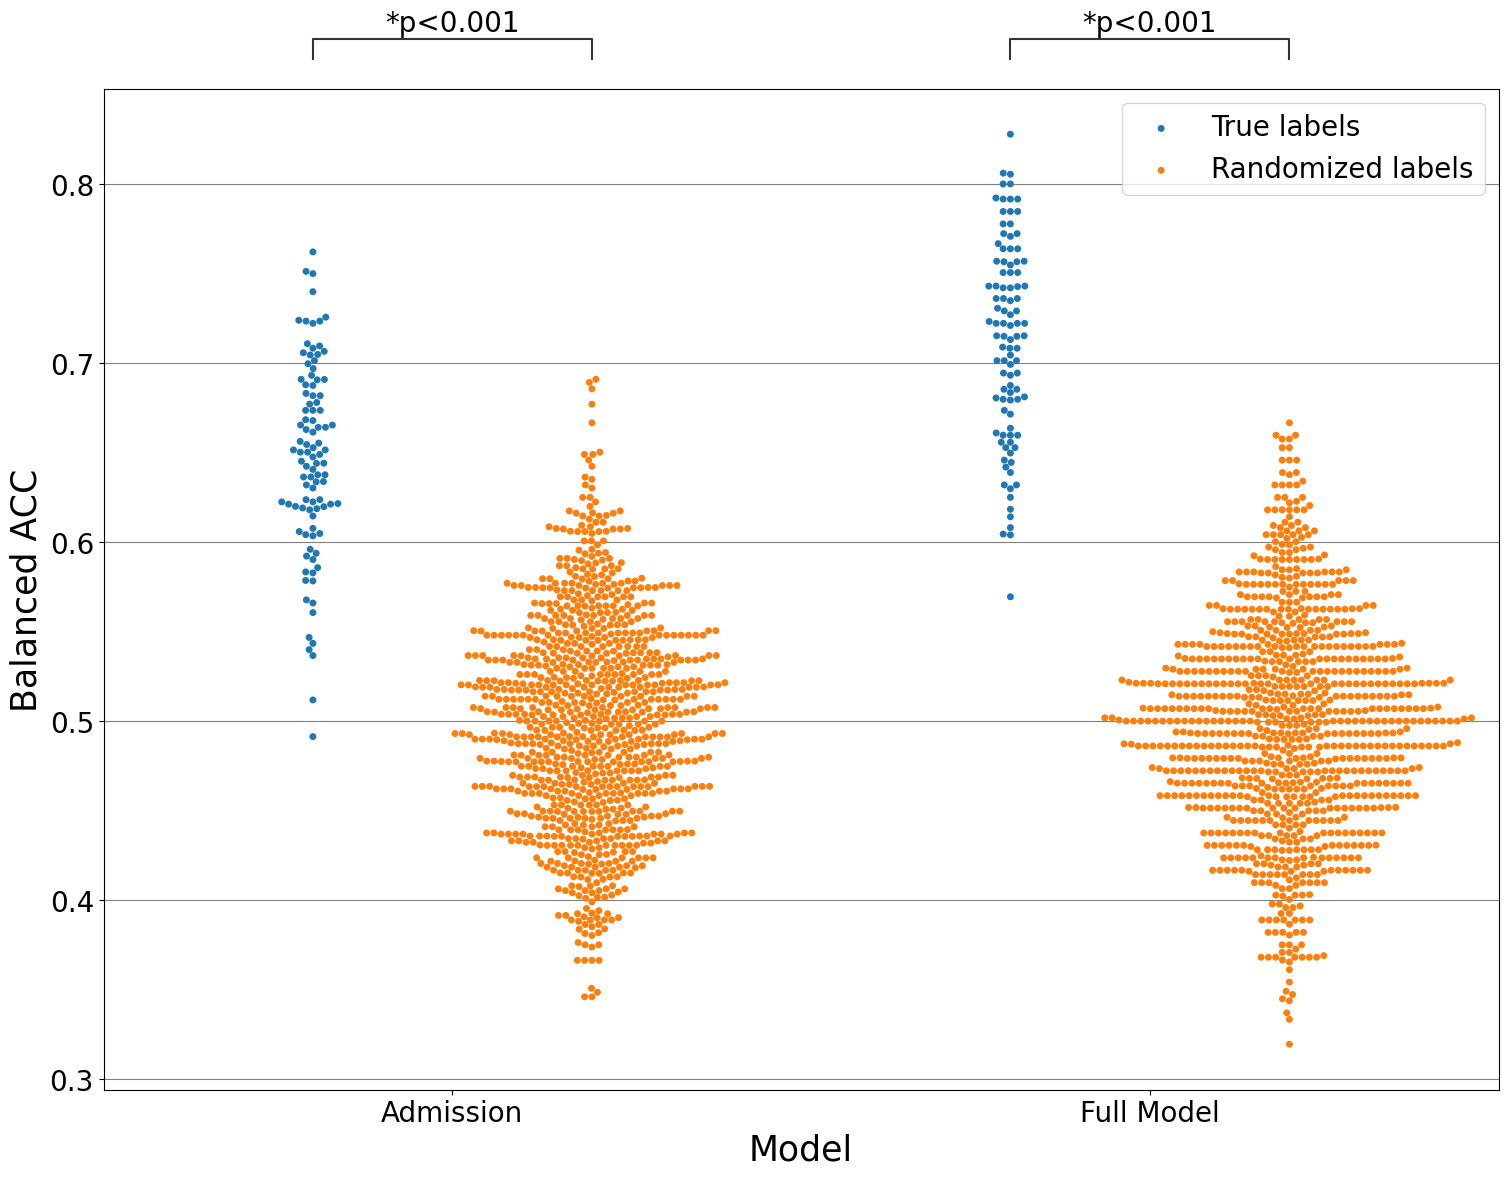

In [ ]:
# Load OPTUNA DATA

root_dir_admission = output_dir / "Admission_model"
root_dir_full = output_dir / "Full_model"

results_full_permuted = pd.read_csv(root_dir_full / "Full_permutation_test.csv")
results_full_permuted = results_full_permuted[
    results_full_permuted["Thresholds"] == 0.5
]
results_full_permuted = results_full_permuted[
    results_full_permuted["Number of Removed Features"] == 0
]
results_full_permuted = results_full_permuted.drop_duplicates(
    subset=["Fold", "Random Permutation Number"], keep="first"
)
results_full_permuted["Model"] = "Full Model"


results_full = pd.read_csv(root_dir_full / "Full_direct_remove.csv", index_col=0)
results_full = results_full[results_full["Thresholds"] == 0.5]
results_full = results_full[results_full["Number of Removed Features"] == 0]
results_full["Random State"] = False


results_admission_permuted = pd.read_csv(root_dir_admission / "Admission_permutation_test.csv")
results_admission_permuted = results_admission_permuted[
    results_admission_permuted["Thresholds"] == 0.5
]


results_admission = pd.read_csv(
    root_dir_admission / "Admission_direct_remove.csv", index_col=0
)

results_admission = results_admission[results_admission["Thresholds"] == 0.5]
results_admission = results_admission[
    results_admission["Number of Removed Features"] == 0
]
results_admission["Random State"] = False

models_to_plot = [
    "Admission",
    "Full Model",
]

res = pd.concat(
    [results_admission, results_admission_permuted, results_full, results_full_permuted]
)
metric_to_plot = "Balanced ACC"

fig, ax = plt.subplots(1, 1, figsize=[18, 13])

sns.swarmplot(
    data=res,
    x="Model",
    y=metric_to_plot,
    dodge=True,
    hue="Random State",
    ax=ax,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[: models_to_plot.__len__()], labels[: models_to_plot.__len__()])
ax.legend(["True labels", "Randomized labels"])

# Comparisons for statistical test
box_list = [
    (("Admission", True), ("Admission", False)),
    (("Full Model", True), ("Full Model", False)),
]
plt.grid(alpha=0.5, axis="y", c="black")

Annotator

annotator = Annotator(ax, box_list, data=res, x="Model", y=metric_to_plot, hue="Random State")
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside',pvalue_thresholds=[[1, "ns"], [0.001, "*p<0.001"]])
annotator.apply_and_annotate()

plt.show()


# Missing value experiment Admission Model

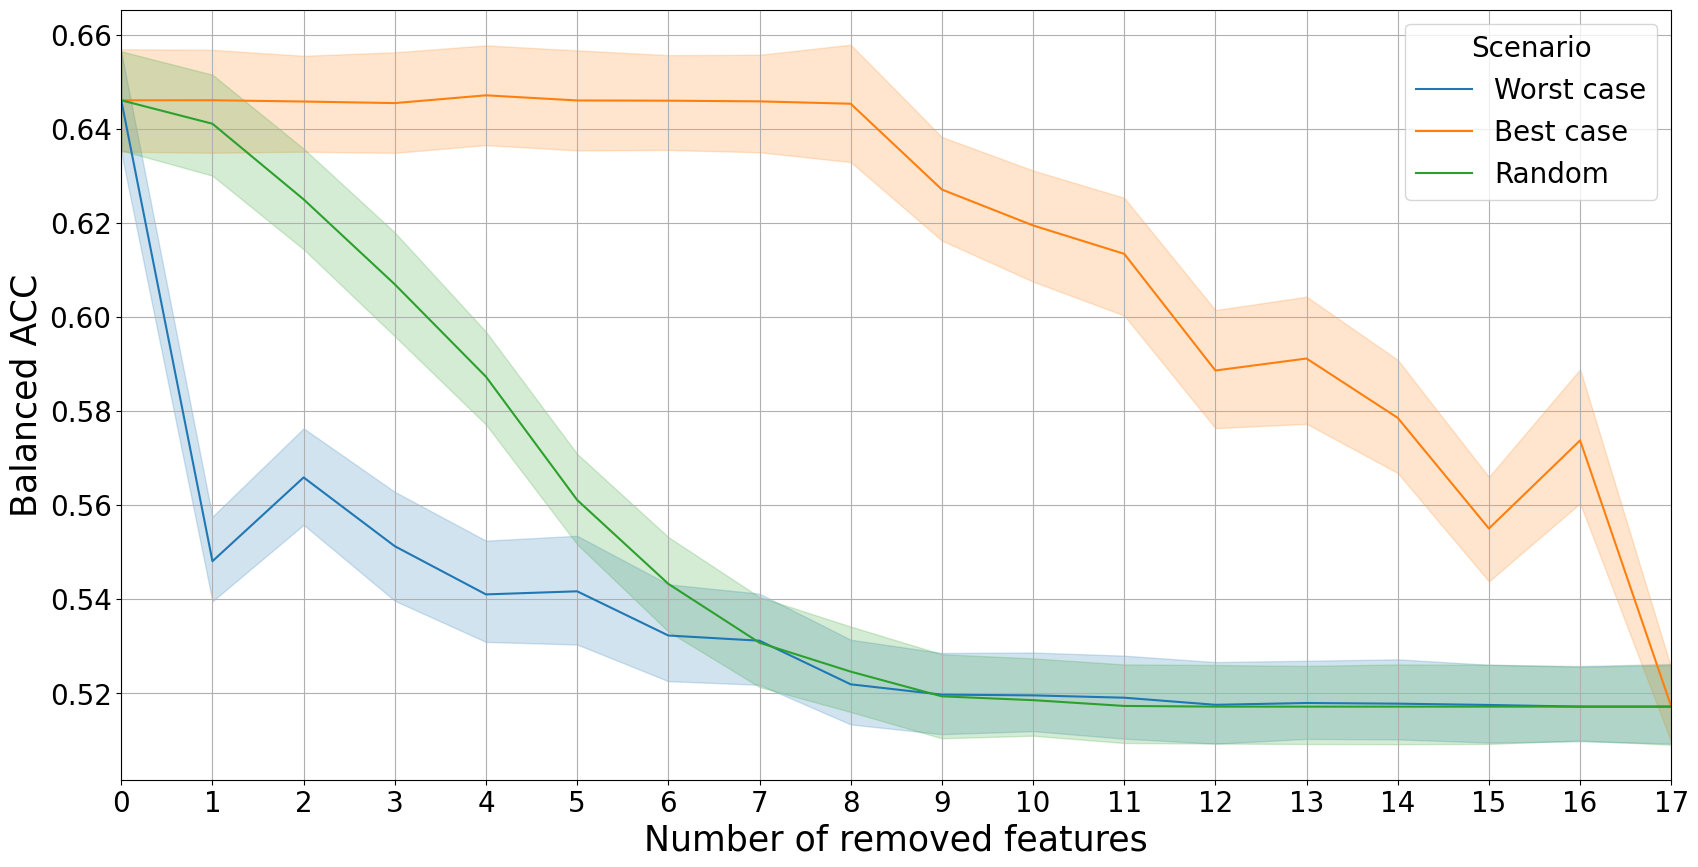

In [ ]:
root_dir_admission = output_dir / "Admission_model"

results_random = pd.read_csv(
    root_dir_admission / "Admission_random_remove.csv", index_col=0
)
results_random = results_random[results_random["Thresholds"] == 0.5]
results_random["Scenario"] = "Random"

results_direct = pd.read_csv(
    root_dir_admission / "Admission_direct_remove.csv", index_col=0
)
results_direct = results_direct[results_direct["Thresholds"] == 0.5]
results_direct["Scenario"] = "Worst case"

results_inverse = pd.read_csv(
    root_dir_admission / "Admission_inverse_remove.csv", index_col=0
)

results_inverse = results_inverse[results_inverse["Thresholds"] == 0.5]
results_inverse["Scenario"] = "Best case"

# Reset index to avoid duplicates
results_random.reset_index(drop=True, inplace=True)
results_direct.reset_index(drop=True, inplace=True)
results_inverse.reset_index(drop=True, inplace=True)
results_mv = pd.concat(
    [results_direct, results_inverse, results_random], ignore_index=True
)


fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "Balanced ACC"
results_mv_to_plot = results_mv[results_mv["Model"] == "Admission"]

sns.lineplot(
    data=results_mv_to_plot,
    x="Number of Removed Features",
    y=metric_to_plot,
    hue="Scenario",
    ax=ax,
)
plt.grid()
plt.xlim(0, 17)
plt.xlabel("Number of removed features")
custom_ticks = np.arange(0, 18, 1)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
# plt.title("Missing values impact in 24hs Model")
plt.show()

# Missing value experiment Full Model

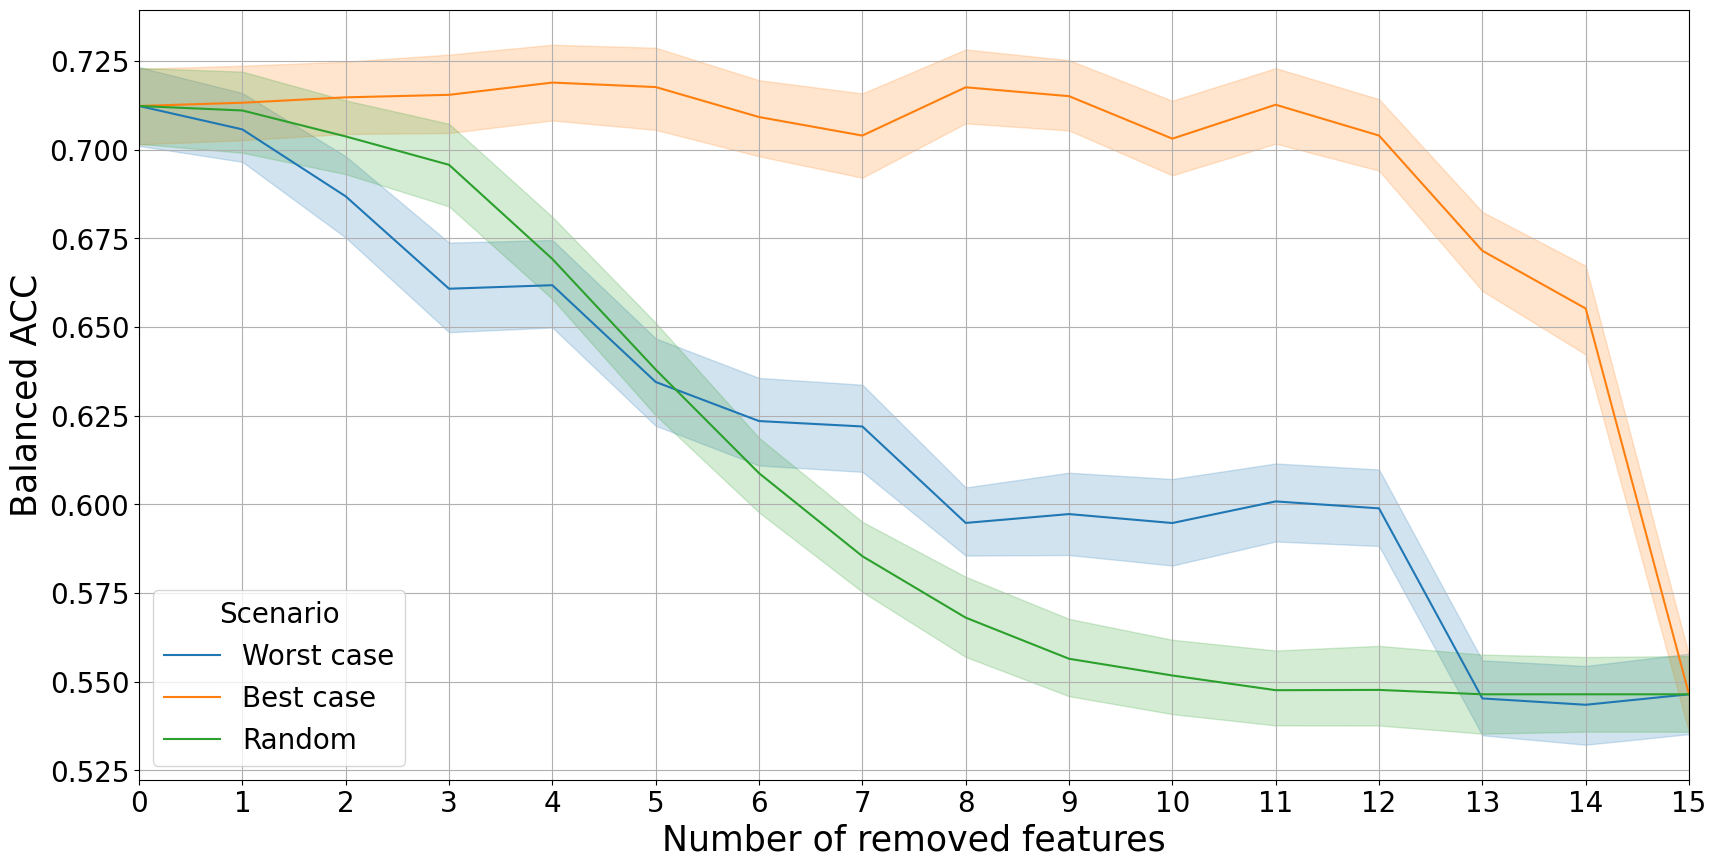

In [ ]:
root_dir_full = output_dir / "Full_model"

results_random = pd.read_csv(root_dir_full / "Full_random_remove.csv", index_col=0)
results_random = results_random[results_random["Thresholds"] == 0.5]
results_random["Scenario"] = "Random"

results_direct = pd.read_csv(root_dir_full / "Full_direct_remove.csv", index_col=0)
results_direct = results_direct[results_direct["Thresholds"] == 0.5]
results_direct["Scenario"] = "Worst case"

results_inverse = pd.read_csv(root_dir_full / "Full_inverse_remove.csv", index_col=0)

results_inverse = results_inverse[results_inverse["Thresholds"] == 0.5]
results_inverse["Scenario"] = "Best case"
# Reset index to avoid duplicates
results_random.reset_index(drop=True, inplace=True)
results_direct.reset_index(drop=True, inplace=True)
results_inverse.reset_index(drop=True, inplace=True)
results_mv = pd.concat(
    [results_direct, results_inverse, results_random], ignore_index=True
)


fig, ax = plt.subplots(1, 1, figsize=[20, 10])
metric_to_plot = "Balanced ACC"
results_mv_to_plot = results_mv[results_mv["Model"] == "Full Model"]

sns.lineplot(
    data=results_mv_to_plot,
    x="Number of Removed Features",
    y=metric_to_plot,
    hue="Scenario",
    ax=ax,
)
plt.grid()
plt.xlim(0, 15)
plt.xlabel("Number of removed features")
custom_ticks = np.arange(0, 16, 1)  # Range from 0 to 1 with step of 0.1
plt.xticks(custom_ticks)
# plt.title("Missing values impact in 24hs Model")
plt.show()

# CaordShock Score 

In [ ]:
root_dir_scores = output_dir / "scores"

results_CardShock = pd.read_csv(root_dir_scores / "CardShock.csv", index_col=0)
results_CardShock = results_CardShock[
    results_CardShock["Number of Removed Features"] == 0
]
results_CardShock = results_CardShock[results_CardShock["Thresholds"] == 0.5]
results_CardShock.drop(
    columns=[
        "Fold",
        "Random State",
        "Random Permutation Number",
        "Thresholds",
        "Number of Removed Features",
        "Recall",
    ],
    inplace=True,
)

results_true_label = pd.concat([results_CardShock])


models_to_plot = [
    "CardShock_Score_test",
]

metrics = ["Balanced ACC", "AUC", "F1", "Specificity", "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(
            results_true_label[results_true_label["Model"] == model][metric].mean(), 3
        )
        results_std = round(
            results_true_label[results_true_label["Model"] == model][metric].std(), 3
        )
        confidence_interval = stats.t.interval(
            0.95,
            len(results_true_label[results_true_label["Model"] == model][metric]) - 1,
            loc=results_mean,
            scale=results_std,
        )

        print(
            metric
            + ": "
            + str(results_mean)
            + " ["
            + str(round(confidence_interval[0], 3))
            + "/"
            + str(round(confidence_interval[1], 3))
            + "]"
        )


CardShock_Score_test
Balanced ACC: 0.567 [0.373/0.761]
AUC: 0.694 [0.418/0.97]
F1: 0.341 [-0.115/0.797]
Specificity: 0.807 [0.454/1.16]
Sensitivity: 0.328 [-0.196/0.852]


# Admission model performance on eICU dataset

In [ ]:
results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/eICU/admission_model/"  # noqa

results_admission = pd.read_csv(
    results_dir + "Admission_performance_CULPRIT_eICU.csv", index_col=0
)
results_admission = results_admission[
    results_admission["Number of Removed Features"] == 0
]
results_admission = results_admission[results_admission["Thresholds"] == 0.5]
results_admission.drop(
    columns=[
        "Fold",
        "Random State",
        "Random Permutation Number",
        "Thresholds",
        "Number of Removed Features",
        "Recall",
    ],
    inplace=True,
)

results_true_label = pd.concat([results_admission])


models_to_plot = ["Admission Train (CULPRIT)", "Admission Test (eICU)"]

metrics = ["Balanced ACC", "AUC", "F1", "Specificity", "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(
            results_true_label[results_true_label["Model"] == model][metric].mean(), 3
        )
        results_std = round(
            results_true_label[results_true_label["Model"] == model][metric].std(), 3
        )

        print(metric + ": " + str(results_mean))


Admission Train (CULPRIT)
Balanced ACC: 0.712
AUC: 0.8
F1: 0.687
Specificity: 0.762
Sensitivity: 0.662
Admission Test (eICU)
Balanced ACC: 0.605
AUC: 0.63
F1: 0.523
Specificity: 0.678
Sensitivity: 0.531


# Full model performance on eICU dataset

In [ ]:
results_dir = (
    "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/eICU/full_model/"  # noqa
)

results = pd.read_csv(results_dir + "Full_performance_CULPRIT_eICU.csv", index_col=0)
results.drop(
    columns=[
        "Fold",
        "Random State",
        "Random Permutation Number",
        "Thresholds",
        "Number of Removed Features",
        "Recall",
    ],
    inplace=True,
)

results_true_label = pd.concat([results])


models_to_plot = ["Full Train (CULPRIT)", "Full test (eICU)"]

metrics = ["Balanced ACC", "AUC", "F1", "Specificity", "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(
            results_true_label[results_true_label["Model"] == model][metric].mean(), 3
        )
        results_std = round(
            results_true_label[results_true_label["Model"] == model][metric].std(), 3
        )

        print(metric + ": " + str(results_mean))


Full Train (CULPRIT)
Balanced ACC: 0.892
AUC: 0.952
F1: 0.872
Specificity: 0.942
Sensitivity: 0.843
Full test (eICU)
Balanced ACC: 0.636
AUC: 0.769
F1: 0.493
Specificity: 0.886
Sensitivity: 0.385


# LG Admission performance

In [ ]:
results_dir = "/home/nnieto/Nico/MODS_project/CULPRIT_project/output/review_1/LG_compare/LG_with_scaler/"  # noqa

results = pd.read_csv(results_dir + "LG_complete_data_admission.csv", index_col=0)
results = results[results["Model"] == "LG_complete_admission_test"]
results = results[results["Number of Removed Features"] == 0]
results = results[results["Thresholds"] == 0.5]
results.drop(
    columns=[
        "Fold",
        "Random State",
        "Random Permutation Number",
        "Thresholds",
        "Number of Removed Features",
        "Recall",
    ],
    inplace=True,
)

results_true_label = pd.concat([results])


models_to_plot = [
    "LG_complete_admission_test",
]

metrics = ["Balanced ACC", "AUC", "F1", "Specificity", "Sensitivity"]

for model in models_to_plot:
    print(model)
    for metric in metrics:
        results_mean = round(
            results_true_label[results_true_label["Model"] == model][metric].mean(), 3
        )
        results_std = round(
            results_true_label[results_true_label["Model"] == model][metric].std(), 3
        )
        confidence_interval = stats.t.interval(
            0.95,
            len(results_true_label[results_true_label["Model"] == model][metric]) - 1,
            loc=results_mean,
            scale=results_std,
        )

        print(
            metric
            + ": "
            + str(results_mean)
            + " ["
            + str(round(confidence_interval[0], 3))
            + "/"
            + str(round(confidence_interval[1], 3))
            + "]"
        )


LG_complete_admission_test
Balanced ACC: 0.669 [0.554/0.784]
AUC: 0.734 [0.615/0.853]
F1: 0.624 [0.487/0.761]
Specificity: 0.737 [0.562/0.912]
Sensitivity: 0.601 [0.418/0.784]
